In [8]:
import tensorflow as tf
import numpy as np
from gaze_utils import prepare_data, train_step, \
heatmap_comparison_using_AUC, test_step, reset_metrics
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from gaze_prediction import GazePrediction
import gym
from gym.wrappers import FrameStack, AtariPreprocessing
from tensorflow.keras.optimizers import Adam, Adadelta

## Prepare a TensorFlow dataset using game frames and gaze heatmaps

In [ ]:
frames_dir = "../../my_repo/asterix/frames"
labels_dir = "../../my_repo/asterix/heatmaps"
window_size = 4

train_ds, val_ds = prepare_data(frames_dir=frames_dir,
                                labels_dir=labels_dir,
                                window_size=window_size,
                                train_size=194_000,
                                batch_size=256
                               )

In [9]:
import numpy as np
for frames, labels in train_ds.take(1):
    print(frames.shape, labels.shape)
    heatmap = labels[0]
    # Pixel values are now in `[0,1]`
    print(np.min(heatmap), np.max(heatmap))

(256, 84, 84, 4) (256, 84, 84)
0.0 0.9880253


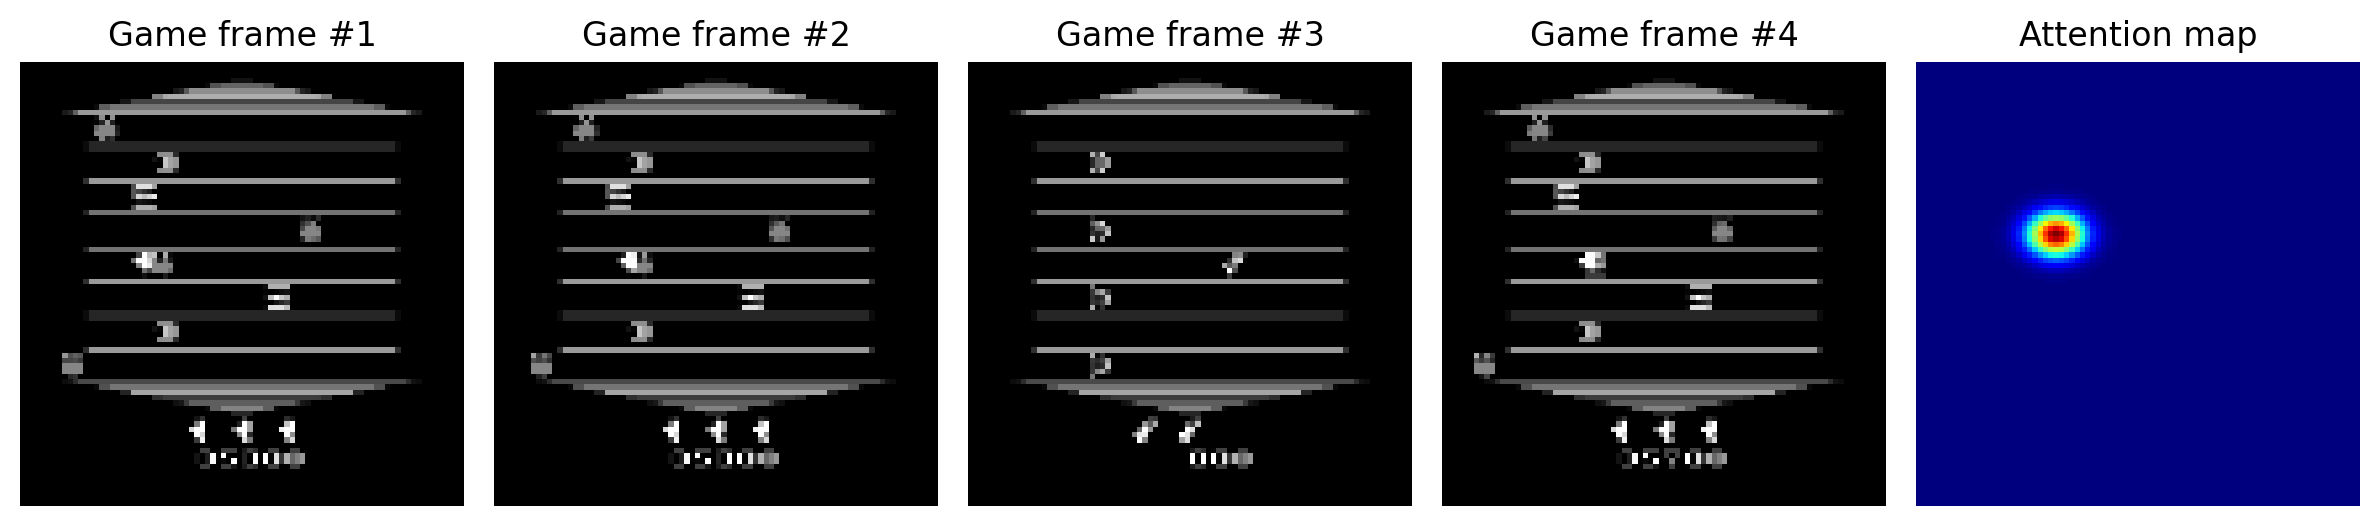

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 3))
ax = ax.ravel()
for frames, labels in train_ds.take(1):
    for i in range(4):
        ax[i].imshow(frames[20,:,:,i], cmap='gray')
        ax[i].set_title(f'Game frame #{i + 1}')
        ax[i].axis("off")

    ax[4].imshow(labels[20], cmap='jet')
    ax[4].set_title('Attention map')  
    ax[4].axis("off");
fig.tight_layout()

## Train the gaze prediction model

In [5]:
tf.keras.backend.clear_session()

# Hyperparameters
epochs = 1
learning_rate = 0.001

# Initialize the model
model = GazePrediction()
loss_fn = tf.keras.losses.KLDivergence()
# optimiser = Adam(learning_rate=learning_rate)
optimiser = Adadelta(learning_rate=1)

# Metrics
loss_metric = tf.keras.metrics.KLDivergence()
hist = {'loss': [], 'val_loss': []}

examples = {"prediction": [], "target": []}

# training
for epoch in range(epochs):
    reset_metrics([loss_metric])
    for inputs, targets in train_ds:
        logs = train_step(model, inputs, targets, loss_fn, optimiser, loss_metric)
    for key, value in logs.items():
        hist[key].append(value)
        if epoch % 20 == 0:
            print(f"Results at the end of epoch {epoch}: \n...{key}: {value:.4f}")

    # test
    reset_metrics([loss_metric])
    for inputs, targets in val_ds:
        logs, predictions = test_step(model, inputs, targets, loss_fn, loss_metric)
    indices = np.random.randint(12)
    examples["prediction"].append(predictions[indices])
    examples["target"].append(targets[indices])
    for key, value in logs.items():
        hist[key].append(value)
        if epoch % 20 == 0:
            print("...Evaluation results:")
            print(f"...{key}: {value:.4f}")
            print("\n")

2022-09-25 21:00:15.367065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-25 21:00:40.534518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Results at the end of epoch 0: 
...loss: 59.3340


2022-09-25 21:01:02.040532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


...Evaluation results:
...val_loss: 77.6211




2022-09-25 21:01:07.890205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [6]:
# save the weights
model.save_weights("gaze_predict_4f_ada", save_format="tf")

## Visualise results

8/8 [==============================] - 0s 17ms/step


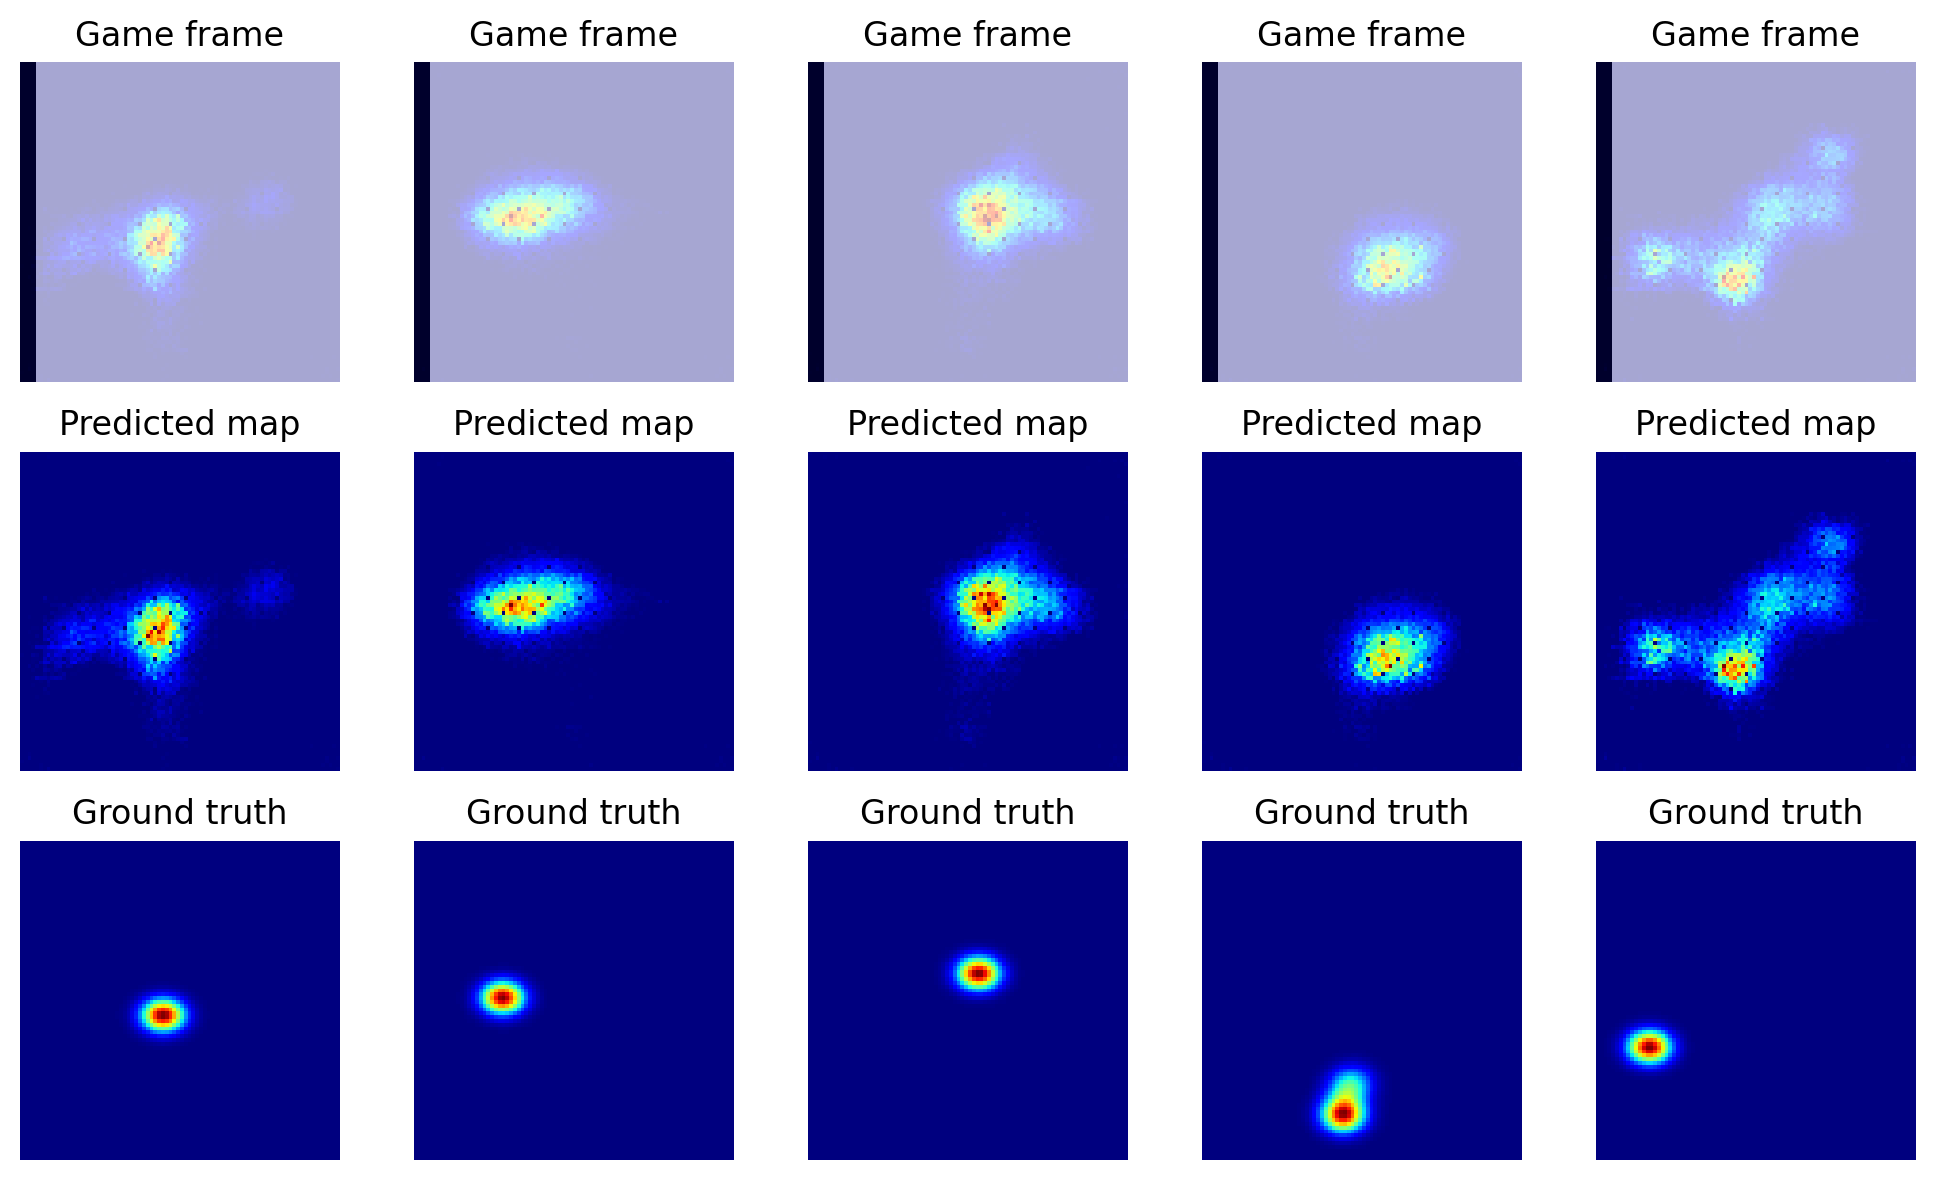

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))
ax = ax.ravel()
for frames, labels in val_ds.take(1):
    predictions = model.predict(frames)
    for i in range(5):
#         auc_score = heatmap_comparison_using_AUC(predictions[i], labels[i])
        
        ax[i].imshow(frames[i][-1], cmap='gray')
        ax[i].set_title('Game frame')
        ax[i].axis("off")
        
        ax[i].imshow(predictions[i], cmap='jet', alpha=.35)
        ax[i].axis("off")

        ax[5 + i].imshow(predictions[i], cmap='jet')
#         ax[5 + i].set_title(f'Predicted map, \nAUC: {auc_score:.2f}')
        ax[5 + i].set_title(f'Predicted map')
        ax[5 + i].axis("off")
        
        ax[10 + i].imshow(labels[i], cmap='jet')
        ax[10 + i].set_title('Ground truth')
        ax[10 + i].axis("off")
fig.tight_layout()

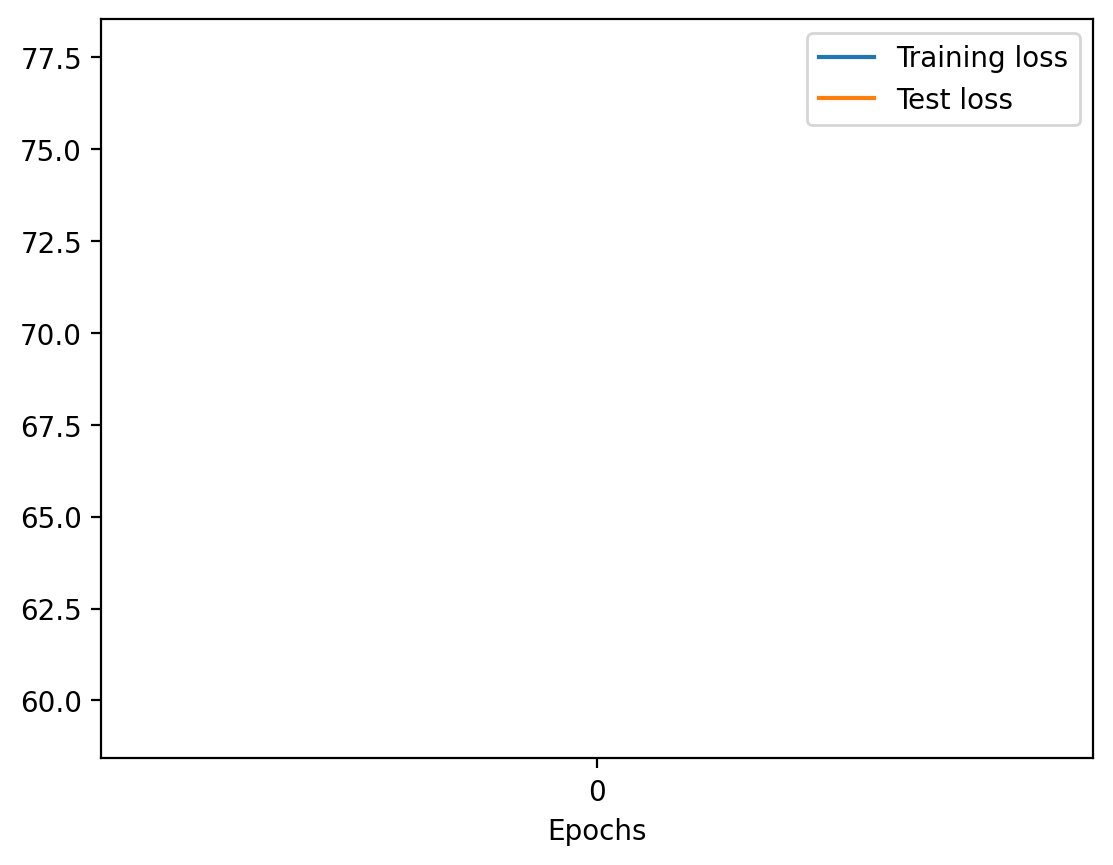

In [16]:
plt.plot(hist['loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Test loss')
plt.xlabel('Epochs')
plt.xticks(np.arange(epochs, step=50))
plt.legend()
plt.show()

## Show predicted gaze distribution on top of a game frame

1/1 [==============================] - 0s 11ms/step


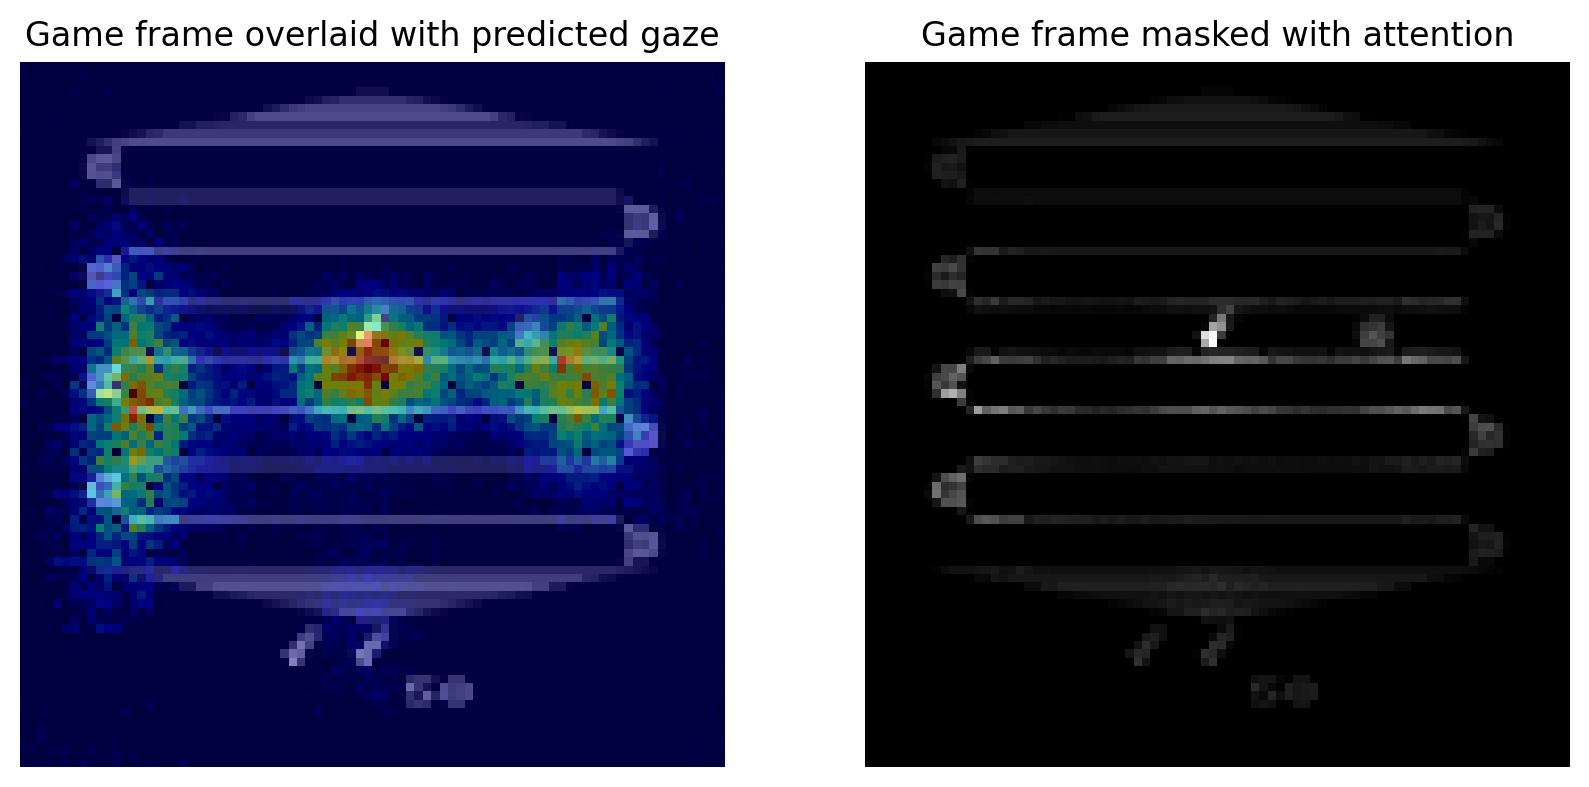

In [23]:
env = gym.make('ALE/Asterix-v5', frameskip=1)
env = AtariPreprocessing(env, frame_skip=4)
# frame stacking with 4 frames
env = FrameStack(env, num_stack=4)
obs = env.reset()
for i in range(100):
    obs, reward, done, info = env.step(0)

fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.imshow(obs[-1], cmap='gray')
plt.axis("off")

inputs = tf.cast(obs, tf.float32)
inputs = tf.expand_dims(inputs, axis=0) # add batch dim
inputs = tf.transpose(inputs, [0, 2, 3, 1]) # channels last

predicted_gaze = model.predict(inputs)

plt.subplot(1, 2, 1)
plt.imshow(tf.squeeze(predicted_gaze).numpy(), cmap='jet', alpha=.5)
plt.title('Game frame overlaid with predicted gaze')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(np.multiply(tf.squeeze(predicted_gaze).numpy(),
                      obs[-1]), cmap='gray')
plt.title('Game frame masked with attention')
plt.axis("off");